# estimate the impact of outreach on CRS savings (Appendix C)
The CRS includes an outreach component where communities are informed how to successfully file their flood loss claims. The outreach itself would not impact actual flood loses. Yet, we expect this outreach to increase the total insurance claims per policy for communities in the CRS. If uncorrected, this would lead to an overall underestimation of the savings from the CRS program. In this notebook, we estimate his effect.

In [1]:
import os, glob
import numpy as np
import astropy.table as aTable
from tqdm.notebook import tqdm, trange

In [2]:
import torch

In [3]:
import corner as DFM
# --- plotting ---
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
if torch.cuda.is_available(): device = 'cuda'
else: device = 'cpu'

## load $\mathcal{Q}^C_\phi(X)
to confirm the support of the control sample

In [5]:
support_control = torch.load('../dat/qphi_support.v2.log.control.pt', map_location=torch.device(device))

In [6]:
def within_support(covar, thresh=-10): 
    logprob_control = support_control.log_prob(
        torch.tensor(covar.astype(np.float32)).to(device)).detach().cpu()[0]
    return [False, True][(logprob_control > thresh)]

## read $q^C_\phi(Y\,|\,X)$
Read an ensemble of trained neural density estimators of $q^C_\phi(Y\,|\,X)$

In [7]:
def read_qphi(nde_name):
    qphis = []
    for fqphi in glob.glob('../dat/nde/%s/*.pt' % nde_name): 
        qphi = torch.load(fqphi, map_location=device)
        qphis.append(qphi)
    return qphis

In [8]:
qphis_control = read_qphi('qphi_control')

# read only c300 data

In [9]:
# 'Claim (log dollars)', 'rainfall', 'flood risk', 'median income', 'population', 'renter fraction', 'educated fraction', 'diversity fraction'
c300only = np.load('../dat/fema_cid.almost_only_c300.npy')

In [10]:
c300only[:,3] = np.log10(c300only[:,3])
c300only[:,4] = np.log10(c300only[:,4])
c300only[:,-1] = 1 - c300only[:,-1]

## compare it to control sample

In [11]:
data = aTable.Table.read('../dat/zipcode.fema.fsf.acs.rainfall.v2.csv', format='csv')
print('%i entries; %i unique zipcodes' % (len(data), len(np.unique(data['reportedZipcode']))))

columns = ['amountPaidOnTotalClaim_per_policy', 'mean_rainfall', 'avg_risk_score_all', 
           'median_household_income', 'population', 'renter_fraction', 'educated_fraction', 'white_fraction'] 
control_data = np.vstack([np.ma.getdata(data[col][(data['communityRatingSystemDiscount'] == 11.)].data) for col in columns]).T
control_data[:,0] = np.log10(control_data[:,0])
control_data[:,3] = np.log10(control_data[:,3])
control_data[:,4] = np.log10(control_data[:,4])

74288 entries; 14729 unique zipcodes


In [12]:
in_control = np.ones(c300only.shape[0]).astype(bool)
for i in trange(c300only.shape[0]):
    if not within_support(c300only[i,1:]): 
        in_control[i] = False
        
print('%i of entries are within the control sample support' % np.sum(in_control))        

  0%|          | 0/1955 [00:00<?, ?it/s]

1144 of entries are within the control sample support


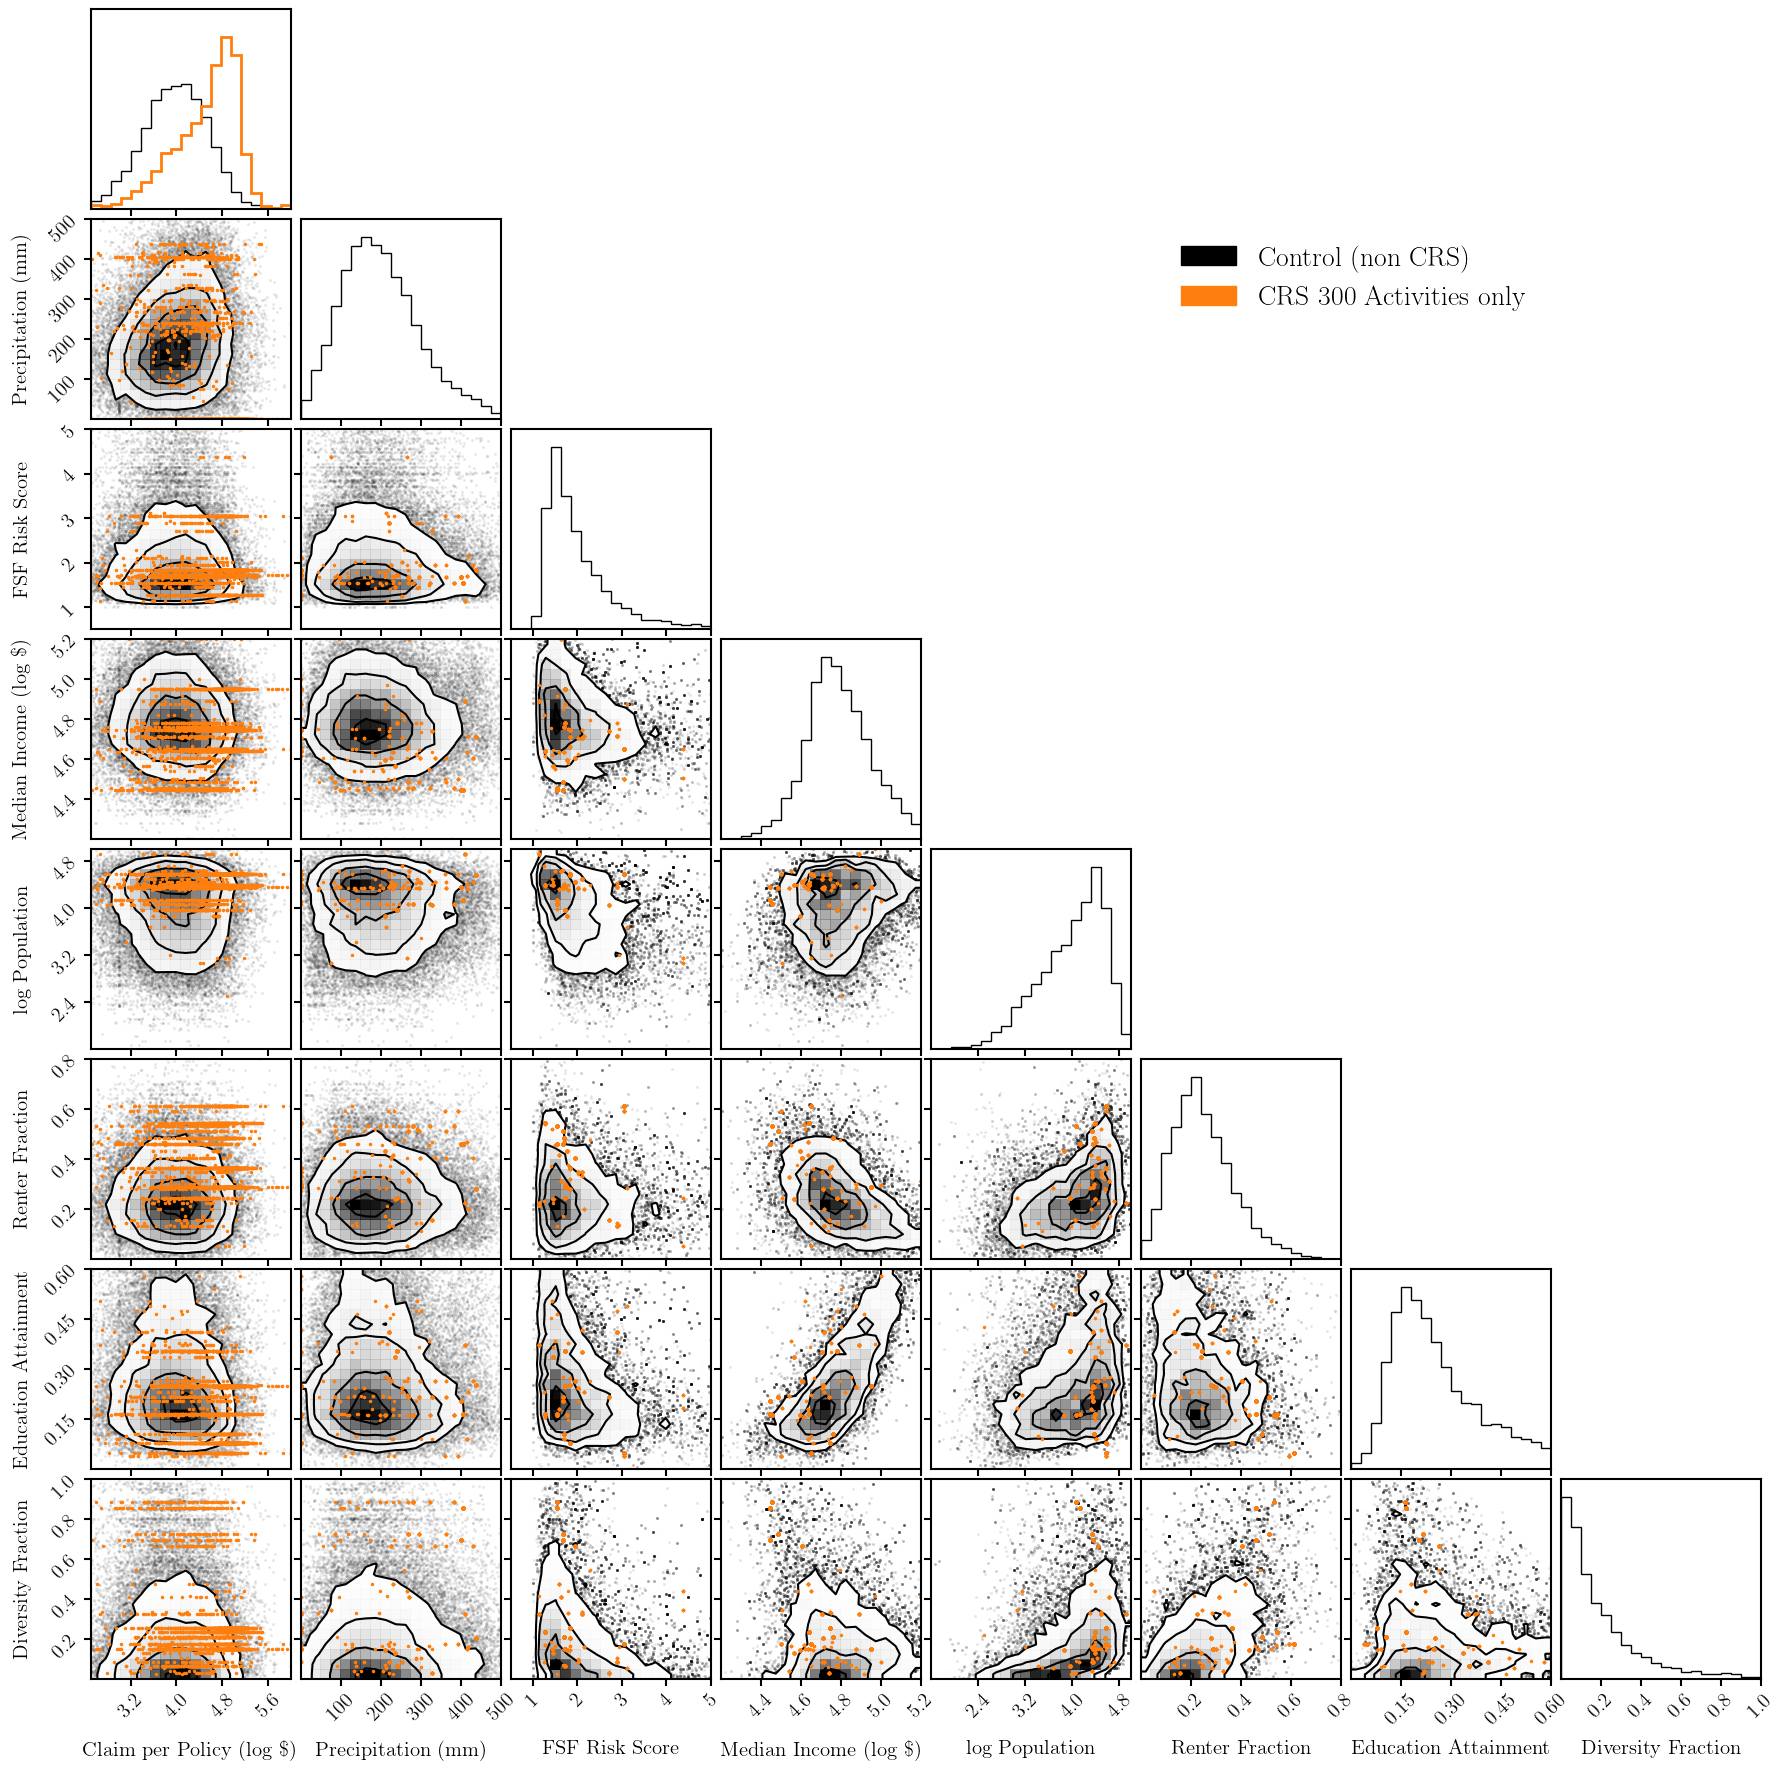

In [13]:
# visually confirm
_data = control_data.copy()
_data[:,-1] = 1 - _data[:,-1] # diversity fraction = 1 - white fraction
fig = DFM.corner(_data, 
                 range=[(2.5, 6.), (0., 500.), (0.5, 5.), (4.2, 5.2), (1.6, 5.0), (0., 0.8), (0., 0.6), (0.0, 1.)], 
                 hist_kwargs={'density': True},
                 labels=['Claim per Policy (log \$)', 'Precipitation (mm)', 'FSF Risk Score', 
                         'Median Income (log \$)', 'log Population', 'Renter Fraction', 
                         'Education Attainment', 'Diversity Fraction'], 
                 label_kwargs={'fontsize': 15})

_data = c300only
_data[:,-1] = 1 - _data[:,-1] # diversity fraction = 1 - white fraction
DFM.overplot_points(fig, _data, color='C1', markersize=3, rasterized=True)

axes = np.array(fig.axes).reshape((8,8))
sub = axes[0,0]
_ = sub.hist(_data[:,0], range=(2.5, 6.), bins=20, 
             color='C1', linewidth=2, density=True, histtype='step')
sub.set_xlim(2.5, 6.)
sub.set_ylim(0, 1.1)

sub = axes[1,6]
sub.fill_between([], [], [], color='k', label='Control (non CRS)')
sub.fill_between([], [], [], color='C1', label='CRS 300 Activities only')
sub.legend(loc='upper right', fontsize=20)

## claim/policy distribution
for communities in the control sample versus the communities that only participated in the outreach efforts

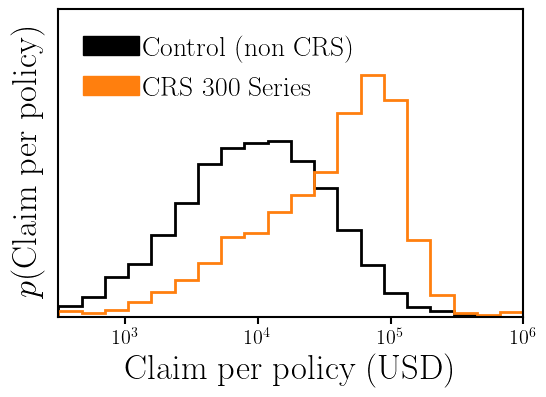

In [14]:
fig = plt.figure(figsize=(6,4))
sub = fig.add_subplot(111)

_data = control_data.copy()
_data[:,-1] = 1 - _data[:,-1]
_ = sub.hist(_data[:,0], range=(2.5, 6.), bins=20, 
             color='k', linewidth=2, density=True, histtype='step')

_data = c300only
_data[:,-1] = 1 - _data[:,-1]

_ = sub.hist(_data[:,0], range=(2.5, 6.), bins=20, 
             color='C1', linewidth=2, density=True, histtype='step')

sub.set_xlabel('Claim per policy (USD)', fontsize=25)
sub.set_xlim(2.5, 6.)
sub.set_xticks([3., 4., 5., 6.])
sub.set_xticklabels([r'$10^%i$' % i for i in [3, 4, 5, 6]])
sub.set_ylim(0, 1.2)
sub.set_yticks([])
sub.set_ylabel(r'$p($Claim per policy$)$', labelpad=10, fontsize=25)

sub.fill_between([], [], [], color='k', label='Control (non CRS)')
sub.fill_between([], [], [], color='C1', label='CRS 300 Series')
sub.legend(loc='upper left', handletextpad=0.15, fontsize=20)
#fig.savefig('../figs/outreach_effect0.pdf', bbox_inches='tight')

# evaluate $q_\phi^{\rm C}(Y\,|\,X)$ at c300 covariates to estimate the impact

In [15]:
n_sample = 100000 

control = np.repeat(-999, c300only.shape[0])
for i in trange(c300only.shape[0]):
    covar = c300only[i,1:]
    
    control_samp = [] 
    for qphi_control in qphis_control: 
        _samp = qphi_control.sample((int(n_sample/len(qphis_control)),), 
                                    x=torch.tensor(covar, dtype=torch.float32).to(device), 
                                    show_progress_bars=False)
        control_samp.append(_samp.detach().cpu().numpy())
    control_samp = np.array(control_samp).flatten()
    control[i] = np.mean(10**control_samp)

  0%|          | 0/1955 [00:00<?, ?it/s]

(-100.0, 300.0)

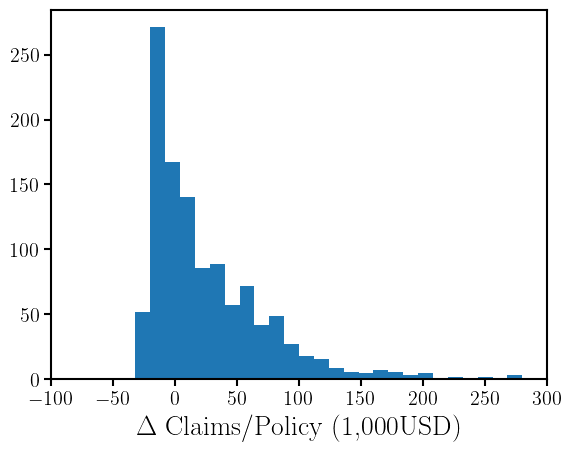

In [16]:
plt.hist((10**c300only[:,0] - control)[in_control]/1e3, range=(-200, 1000), bins=100,)
plt.xlabel('$\Delta$ Claims/Policy (1,000USD)', fontsize=20)
plt.xlim(-100, 300)

In [18]:
print('Outreach activities have a %.2f USD effect on claim/policy' % np.median((10**c300only[:,0] - control)[in_control]))

Outreach activities have a 10620.62 USD effect on claim/policy
